### 10X: SVanalyzer

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
    * 194 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** EM, HR, IC

In [22]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/TenX_EM_HR_IC_HG002_DEL_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/TenX_EM_HR_IC_HG002_DEL_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1,HG002,23,72766323,72811839,-45516,Deletion,Deletion,0,0,...,5.0,0.0,537.636364,21.424382,44.0,350.090909,123.341142,44.0,NaN,0.0


In [3]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/TenX_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/TenX_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,24.0,0.0,529.093023,21.757451,43.0,348.418605,115.713606,40.0,0.0,3.0


In [4]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label', 'TenX.HP1_amb_reason_alignmentScore_insertSizeScore'}

In [5]:
### Drop columns that are not shared by both dataframes
df_train.drop(['TenX.HP1_amb_reason_alignmentScore_insertSizeScore'], axis=1, inplace = True)
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconswithoutTenX.GT'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [6]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,5.0,0.0,537.636364,21.424382,44.0,350.090909,123.341142,44.0,NaN,0.0


In [7]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [8]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTconswithoutTenX.GT',
 'GTsupp',
 'SVtype',
 'id',
 'sample',
 'type'}

In [9]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTconswithoutTenX.GT'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [10]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,5.0,0.0,537.636364,21.424382,44.0,350.090909,123.341142,44.0,NaN,0.0
1,1,96139975,96142391,-2416,0,0,0,0.000000,2,0.014487,...,3.0,0.0,498.000000,0.000000,1.0,480.000000,0.000000,1.0,NaN,0.0
2,1,109690878,109690918,-39,0,0,0,0.000000,1,0.400000,...,3.0,5.0,527.000000,0.000000,1.0,334.000000,0.000000,1.0,NaN,0.0


In [11]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/2518 with 8 missing, elapsed time: 3.756
Imputing row 101/2518 with 8 missing, elapsed time: 3.850
Imputing row 201/2518 with 8 missing, elapsed time: 3.888
Imputing row 301/2518 with 8 missing, elapsed time: 3.930
Imputing row 401/2518 with 8 missing, elapsed time: 3.970
Imputing row 501/2518 with 8 missing, elapsed time: 4.012
Imputing row 601/2518 with 8 missing, elapsed time: 4.046
Imputing row 701/2518 with 8 missing, elapsed time: 4.087
Imputing row 801/2518 with 8 missing, elapsed time: 4.126
Imputing row 901/2518 with 8 missing, elapsed time: 4.196
Imputing row 1001/2518 with 8 missing, elapsed time: 4.237
Imputing row 1101/2518 with 8 missing, elapsed time: 4.275
Imputing row 1201/2518 with 8 missing, elapsed time: 4.317
Imputing row 1301/2518 with 8 missing, elapsed time: 4.354
Imputing row 1401/2518 with 8 missing, elapsed time: 4.398
Imputing row 1501/2518 with 8 missing, elapsed time: 4.444
Imputing row 1601/2518 with 8 missing, elapsed time: 4.489
Imputing 

In [12]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1.0,72766323.0,72811839.0,-45516.0,0.0,0.0,4.0,0.076523,110.0,0.059979,...,5.0,0.0,537.636364,21.424382,44.0,350.090909,123.341142,44.0,0.0,0.0
1,1.0,96139975.0,96142391.0,-2416.0,0.0,0.0,0.0,0.000000,2.0,0.014487,...,3.0,0.0,498.000000,0.000000,1.0,480.000000,0.000000,1.0,0.0,0.0
2,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.400000,...,3.0,5.0,527.000000,0.000000,1.0,334.000000,0.000000,1.0,0.0,0.0


In [13]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['Label']

In [14]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

1.0    818
0.0    964
2.0    736
dtype: int64

In [15]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [16]:
# Remove labels from feature set
X.drop(['Label'],axis=1, inplace = True)

In [17]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_1)
       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model will be used to predict labels for 5000 randomly selected deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_1'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
    

** Train Random Forest Classifier **

<a id='train_test'></a>

In [18]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [19]:
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

** GridSearchCV: Find Optimal Model Parameters **

In [23]:
n = [10, 25, 50, 100, 200, 300, 500, 1000]
param_grid = {'n_estimators': [10, 25, 50, 100, 200, 300, 500, 1000]}
grid = GridSearchCV(model, param_grid, scoring = 'accuracy')

In [24]:
grid.fit(X4, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100, 200, 300, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [25]:
grid.grid_scores_

[mean: 0.73392, std: 0.00847, params: {'n_estimators': 10},
 mean: 0.75099, std: 0.00938, params: {'n_estimators': 25},
 mean: 0.75695, std: 0.01136, params: {'n_estimators': 50},
 mean: 0.75060, std: 0.00930, params: {'n_estimators': 100},
 mean: 0.75774, std: 0.00978, params: {'n_estimators': 200},
 mean: 0.76291, std: 0.01101, params: {'n_estimators': 300},
 mean: 0.76330, std: 0.00748, params: {'n_estimators': 500},
 mean: 0.76052, std: 0.01123, params: {'n_estimators': 1000}]

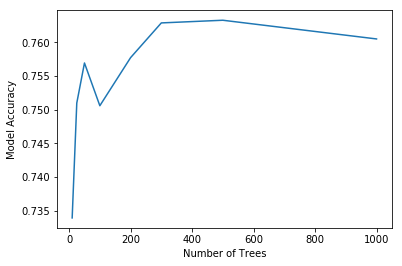

In [26]:
n = [10, 25, 50, 100, 200, 300, 500, 1000]
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
plt.plot(n, grid_mean_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Model Accuracy')
plt.show()

In [27]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.7633042096902304
{'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


** Train Model Using Optimal Parameters**

In [28]:
model = RandomForestClassifier(n_estimators=500) 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



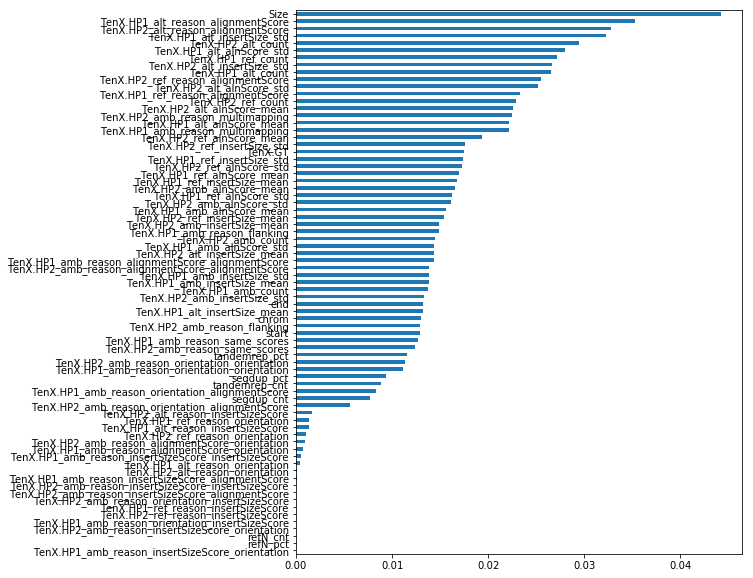

In [30]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(8,10))

In [ ]:
# # Feature Importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# print("Feature ranking:")

# for f in range(X_test.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

<a id='feature_importance'></a>

In [31]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

2.0    514
1.0    581
0.0    667
dtype: int64

In [32]:
pred = model.predict(X_test)

<a id='traintest_precision'></a>

In [33]:
precision_score(pred, y_test, average='micro') 

0.76719576719576721

In [34]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Size,TenX.GT,TenX.HP1_alt_alnScore_mean,TenX.HP1_alt_alnScore_std,TenX.HP1_alt_count,TenX.HP1_alt_insertSize_mean,TenX.HP1_alt_insertSize_std,TenX.HP1_alt_reason_alignmentScore,TenX.HP1_alt_reason_insertSizeScore,TenX.HP1_alt_reason_orientation,...,TenX.HP2_ref_reason_orientation,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
840,-310.0,-1.0,538.000000,0.000000,1.0,322.000000,0.000000,0.0,1.0,0.0,...,0.0,1.0,81119729.0,0.0,0.0,0.0,0.0,81119419.0,1.0,0.064516
1264,-594.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,2.0,121798399.0,0.0,0.0,0.0,0.0,121797805.0,2.0,0.069024
575,-24.0,-1.0,516.363636,13.930168,11.0,286.272727,73.406825,11.0,0.0,0.0,...,0.0,5.0,160610814.0,0.0,0.0,0.0,0.0,160610789.0,0.0,0.000000
944,-20.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,11.0,34449173.0,0.0,0.0,0.0,0.0,34449152.0,1.0,1.000000
2275,-826.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,4.0,174720593.0,0.0,0.0,0.0,0.0,174719767.0,6.0,0.500000


In [35]:
labels = pd.DataFrame(y_test)

In [36]:
df_Xtest['predicted_label'] = pred
df_Xtest['Label'] = df_train['Label']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [37]:
pd.value_counts(df_Xtest['Label'].values, sort=False)

0    297
1    237
2    222
dtype: int64

In [38]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

0.0    319
1.0    257
2.0    180
dtype: int64

In [39]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['Label']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[243  23  31]
 [  5 210  22]
 [ 71  24 127]]


In [40]:
df_Xtest['Label'].replace(0, 'Homozygous_Refernce', inplace=True)
df_Xtest['Label'].replace(1, 'Exact_Match', inplace=True)
df_Xtest['Label'].replace(2, 'Inaccurate_Call', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Refernce', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Exact_Match', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

<a id='traintest_confusion_matrix'></a>

In [41]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Exact_Match,Homozygous_Refernce,Inaccurate_Call,All
True,,,,
Exact_Match,210,5,22,237
Homozygous_Refernce,23,243,31,297
Inaccurate_Call,24,71,127,222
All,257,319,180,756


In [42]:
from sklearn.metrics import classification_report
print(classification_report(predict,ytest))

                     precision    recall  f1-score   support

        Exact_Match       0.89      0.82      0.85       257
Homozygous_Refernce       0.82      0.76      0.79       319
    Inaccurate_Call       0.57      0.71      0.63       180

        avg / total       0.78      0.77      0.77       756



***
Predict
***

Description:

   * In the [previous section](#machine_learning) the model was trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_2)
       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_2'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
   

** Load Data **

In [ ]:
X2 = df_test

** Impute missing values using KNN **

In [ ]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

In [ ]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

In [ ]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

In [ ]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

<a id='prediction_step'></a>

In [ ]:
pred = model.predict(X5)

In [ ]:
pred_prob = model.predict_proba(X5)

In [ ]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']
X5['GTconswithoutTenX.GT'] = df_test_2['GTconswithoutTenX.GT']

In [ ]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/TenX_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [ ]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/TenX_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv')

In [ ]:
X6.rename(columns={'1': 'Homozygous_Reference_SVan_predprob_TenX'}, inplace=True)
X6.rename(columns={'2': 'Exact_Match_predprob_TenX'}, inplace=True)
X6.rename(columns={'3': 'Inaccurate_Call_predprob_TenX'}, inplace=True)
X6.rename(columns={'predicted_label': 'TenX_predicted_EMHRIC_label'}, inplace=True)

In [ ]:
X6.head(3)

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/TenX_final_df_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

***
Label Analysis
***

Description:
  * Comparison of model predicted labels [Exact Match, Homozygous Reference, Inaccurate Calls] to consensus genotype for the 5000 randomly selected datapoints from union_refalt.vcf for HG002 only

In [ ]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['TenX_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

In [ ]:
from sklearn.metrics import confusion_matrix
GT_without_XX = X6['GTconswithoutTenX.GT']
predict = X6['TenX_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

In [ ]:
pd.value_counts(X6['GTconswithoutTenX.GT'].values, sort=False)

In [ ]:
pd.value_counts(X6['GTcons'].values, sort=False)

In [ ]:
X6['GTcons'].replace(-1, 'Unknown', inplace=True)
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['TenX_predicted_EMHRIC_label'].replace(0.0, 'Homozygous_Reference_SVan', inplace=True)
X6['TenX_predicted_EMHRIC_label'].replace(1.0, 'Exact_Match', inplace=True)
X6['TenX_predicted_EMHRIC_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [ ]:
X6['GTconswithoutTenX.GT'].replace(-1, 'Unknown', inplace=True)
X6['GTconswithoutTenX.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutTenX.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutTenX.GT'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='svan_gtcons'></a>

** Compare SVanalyzer Labels to GTcons **

In [ ]:
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

** Compare SVanalyzer Labels to LOO Consensus GT **

In [ ]:
pd.crosstab(GT_without_XX, predict, rownames=['GTcons_withoutXX'], colnames=['SVanalyzer_Label'], margins=True)

** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following svanalyzer labels:
    * Homozygous Reference: 0 
    * Exact Match: 1 
    * Inaccurate Call: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [ ]:
high_conf_labels = X6[(X6['Homozygous_Reference_SVan_predprob_TenX'] == 1) | (X6['Homozygous_Reference_SVan_predprob_TenX'] == 0.9) | (X6['Exact_Match_predprob_TenX'] == 1) | (X6['Exact_Match_predprob_TenX'] == 0.9) | (X6['Inaccurate_Call_predprob_TenX'] == 1) | (X6['Inaccurate_Call_predprob_TenX'] == 0.9)]

** Consensus Genotype versus SVanalyzer Labels **

In [ ]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['TenX_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

** LOO Genotype versus SVanalyzer Labels **

In [ ]:
consensus_GT = high_conf_labels['GTconswithoutTenX.GT']
predict = high_conf_labels['TenX_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons_without_XX'], colnames=['SVanalyzer_Label'], margins=True)

***
Graphs
***

** Exact Match **

In [ ]:
em = X5['predicted_label'] == 1.0
exact_match = X5[em]

In [ ]:
exact_match.head(1)

In [ ]:
output_notebook()

In [ ]:
p = figure()
p = Histogram(exact_match, values='GTcons', title='Exact_Match_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Homozygous Reference **

In [ ]:
hr = X5['predicted_label'] == 0.0
hom_ref = X5[hr]
hom_ref.head(1)

In [ ]:
p = figure()
p = Histogram(hom_ref, values='GTcons', title='Homozygous_Reference_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Inaccurate Call **

In [ ]:
ic = X5['predicted_label'] == 2.0
inac_call = X5[ic]
inac_call.head(1)

In [ ]:
p = figure()
p = Histogram(inac_call, values='GTcons', title='Inaccurate_Call_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)